# **Importing Libraries**

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import cv2

from PIL import Image

from tensorflow import keras
import tensorflow.keras.layers as k

from tqdm.notebook import tqdm

# **Data**

In [55]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img

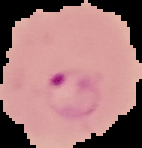

In [56]:
load_img('/content/MalarialCellImageData/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png')

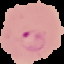

In [57]:
#changing the size of the image so that model trains on less features
load_img('/content/MalarialCellImageData/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png',target_size = (64,64))

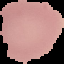

In [58]:
load_img('/content/MalarialCellImageData/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_34.png',
        target_size = (64,64))

In [59]:
os.environ['KERAS_BACKEND'] = 'tensorflow'
np.random.seed(312)

In [60]:
image_dir = '/content/MalarialCellImageData/malarial_cell_image_data/cell_images/cell_images/'
size = 64
dataset = []
label = []

In [61]:
parasitized_img = os.listdir(image_dir+'Parasitized/')
for i,img_name in enumerate(tqdm(parasitized_img)):
  if (img_name.split('.')[1] == 'png'):
    image = cv2.imread(image_dir+'Parasitized/'+img_name)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(0)

  0%|          | 0/13780 [00:00<?, ?it/s]

In [62]:
uninfected_img = os.listdir(image_dir+'Uninfected/')
for i,img_name in enumerate(tqdm(uninfected_img)):
  if (img_name.split('.')[1] == 'png'):
    image = cv2.imread(image_dir+'Uninfected/'+img_name)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(1)

  0%|          | 0/13780 [00:00<?, ?it/s]

In [63]:
print(len(parasitized_img),len(uninfected_img))

13780 13780


In [64]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

xtrain,xtest,ytrain,ytest = train_test_split(dataset,to_categorical(np.array(label)), test_size = 0.2, random_state = 0)

# **CNN MODEL Architecture**

In [65]:
INPUT_SHAPE = (size,size,3)
inp = k.Input(shape = INPUT_SHAPE)

conv1 = k.Conv2D(32, kernel_size = (3,3), activation = "relu", padding = "same")(inp)
pool1 = k.MaxPool2D(pool_size = (2,2))(conv1)
norm1 = k.BatchNormalization(axis = -1)(pool1)
drop1 = k.Dropout(rate = 0.2)(norm1)

conv2 = k.Conv2D(32, kernel_size = (3,3), activation = "relu", padding = "same")(drop1)
pool2 = k.MaxPool2D(pool_size = (2,2))(conv2)
norm2 = k.BatchNormalization(axis = -1)(pool2)
drop2 = k.Dropout(rate = 0.2)(norm2)

flat = k.Flatten()(drop2)

hidden1 = k.Dense(512, activation = 'relu')(flat)
norm3 = k.BatchNormalization(axis = -1)(hidden1)
drop3 = k.Dropout(rate = 0.2)(norm3)

hidden2 = k.Dense(256, activation = 'relu')(drop3)
norm4 = k.BatchNormalization(axis = -1)(hidden2)
drop4 = k.Dropout(rate = 0.2)(norm4)

out = k.Dense(2, activation = 'sigmoid')(drop4)

In [69]:
from keras.utils.sidecar_evaluator import optimizer

model = keras.Model(inputs = inp, outputs = out)
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248

In [70]:
history = model.fit(np.array(xtrain), ytrain, batch_size=64, verbose=1, epochs = 5, validation_split=0.1, shuffle = False)

Epoch 1/5
311/311 [==============================] - 168s 530ms/step - loss: 0.5549 - accuracy: 0.7494 - val_loss: 0.8476 - val_accuracy: 0.8245
Epoch 2/5
311/311 [==============================] - 154s 496ms/step - loss: 0.2342 - accuracy: 0.9112 - val_loss: 0.3253 - val_accuracy: 0.8857
Epoch 3/5
311/311 [==============================] - 155s 497ms/step - loss: 0.1878 - accuracy: 0.9304 - val_loss: 0.3054 - val_accuracy: 0.9070
Epoch 4/5
311/311 [==============================] - 154s 496ms/step - loss: 0.1584 - accuracy: 0.9427 - val_loss: 0.2358 - val_accuracy: 0.9057
Epoch 5/5
311/311 [==============================] - 151s 486ms/step - loss: 0.1380 - accuracy: 0.9499 - val_loss: 0.5065 - val_accuracy: 0.7628


In [71]:
print("Test accuracy: {:.2f}%".format(model.evaluate(np.array(xtest),np.array(ytest))[1]*100))
# to improve accuracy more epochs/iterations required

173/173 [==============================] - 10s 60ms/step - loss: 0.4835 - accuracy: 0.7643
Test accuracy: 76.43%


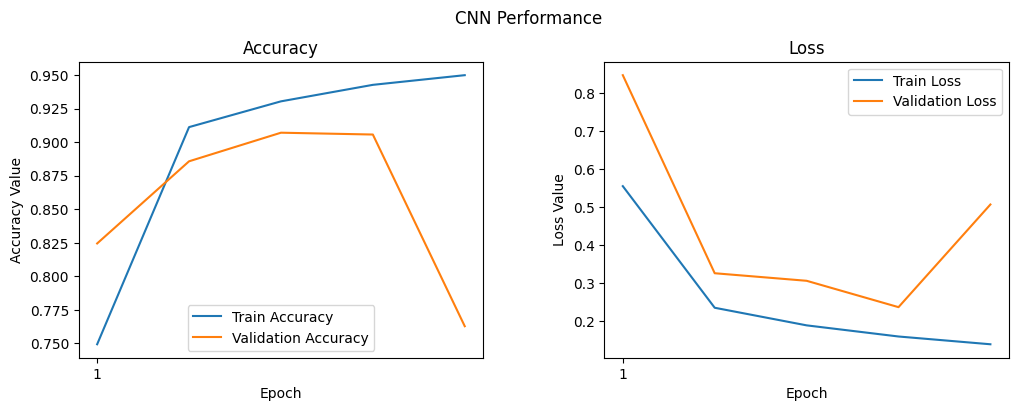

In [73]:
f,(ax1,ax2) = plt.subplots(1,2,figsize = (12,4))
t = f.suptitle('CNN Performance',fontsize=12)
f.subplots_adjust(top = 0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list,history.history['accuracy'],label = 'Train Accuracy')
ax1.plot(epoch_list,history.history['val_accuracy'],label = 'Validation Accuracy')
ax1.set_xticks(np.arange(1,max_epoch,5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc = "best")

ax2.plot(epoch_list,history.history['loss'],label = 'Train Loss')
ax2.plot(epoch_list,history.history['val_loss'],label = 'Validation Loss')
ax2.set_xticks(np.arange(1,max_epoch,5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc = "best")